In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns  # For correlation heatmap
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import tensorflow as tf

Seed Fixing

In [2]:
def set_seeds(seed=42):
    random.seed(seed) # Seed Python RNG
    np.random.seed(seed) # Seed NumPy RNG
    tf.random.set_seed(seed) # Seed TensorFlow RNG
    os.environ['PYTHONHASHSEED'] = str(seed) # Hash seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1' # Force deterministic ops

# SET THE SEED HERE - Use the same seed to get consistent results
set_seeds(42)

Load Data

In [3]:
df = pd.read_csv('AAPL_2000_2024.csv', skiprows=[0,1])
df = df.rename(columns={
    'Date': 'date',
    'Unnamed: 1': 'close',
    'Unnamed: 2': 'high',
    'Unnamed: 3': 'low',
    'Unnamed: 4': 'open',
    'Unnamed: 5': 'volume'
})

df['date'] = pd.to_datetime(df['date']) # Parse date column as datetime

In [4]:
df.head()

,date,close,high,low,open,volume
0,2000-01-03,0.839281,0.843498,0.762428,0.786328,535796800
1,2000-01-04,0.768521,0.829440,0.758680,0.811633,512377600
2,2000-01-05,0.779767,0.828971,0.772269,0.777892,778321600
3,2000-01-06,0.712287,0.802260,0.712287,0.795700,767972800
4,2000-01-07,0.746027,0.757274,0.716036,0.723534,460734400


In [5]:
df.describe()

,date,close,high,low,open,volume
count,6287,6287.000000,6287.000000,6287.000000,6287.000000,6.287000e+03
mean,2012-07-01 14:07:14.038492160,41.040398,41.443332,40.594872,41.006860,3.860308e+08
min,2000-01-03 00:00:00,0.196741,0.197791,0.190743,0.194792,2.323470e+07
25%,2006-04-04 12:00:00,2.004451,2.035642,1.964714,2.007450,1.157234e+08
50%,2012-06-29 00:00:00,13.778256,13.923683,13.662720,13.812350,2.683296e+08
75%,2018-09-27 12:00:00,43.994457,44.332717,43.653687,43.984246,5.184592e+08
max,2024-12-27 00:00:00,257.853760,258.928914,256.470034,257.027510,7.421641e+09
std,NaN,59.852211,60.412486,59.214880,59.784582,3.837453e+08


Filter Last 5 Years

In [6]:
# CRITICAL FIX: USE ONLY LAST 5 YEARS
# Much more consistent price range !!!!!

cutoff_date = pd.to_datetime('2019-01-01') # Start of recent window
df = df[df['date'] >= cutoff_date].reset_index(drop=True) # Keep only recent rows

In [7]:
df.head()

,date,close,high,low,open,volume
0,2019-01-02,37.538815,37.759885,36.661672,36.818560,148158800
1,2019-01-03,33.799686,34.638795,33.754521,34.225182,365248800
2,2019-01-04,35.242558,35.311495,34.182383,34.355908,234428400
3,2019-01-07,35.164116,35.378055,34.681569,35.347152,219111200
4,2019-01-08,35.834454,36.088803,35.304366,35.551581,164101200


In [8]:
df.describe()

,date,close,high,low,open,volume
count,1508,1508.000000,1508.000000,1508.000000,1508.000000,1.508000e+03
mean,2021-12-29 09:52:59.840848640,134.531701,135.863928,133.035578,134.385868,9.424288e+07
min,2019-01-02 00:00:00,33.799686,34.638795,33.754521,34.225182,2.323470e+07
25%,2020-06-30 18:00:00,88.473713,89.739597,87.715278,88.479171,5.918350e+07
50%,2021-12-28 12:00:00,142.934860,144.472291,141.244696,142.788440,8.155695e+07
75%,2023-06-29 06:00:00,171.640224,173.123355,169.779226,171.511204,1.124405e+08
max,2024-12-27 00:00:00,257.853760,258.928914,256.470034,257.027510,4.265100e+08
std,NaN,53.869427,54.260439,53.400517,53.812245,5.231947e+07


Exploratory Data Analysis (EDA)

In [9]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Data completeness: {(1 - df.isnull().sum().sum() / df.size) * 100:.2f}%")


Missing values per column:
date      0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

Total missing values: 0
Data completeness: 100.00%


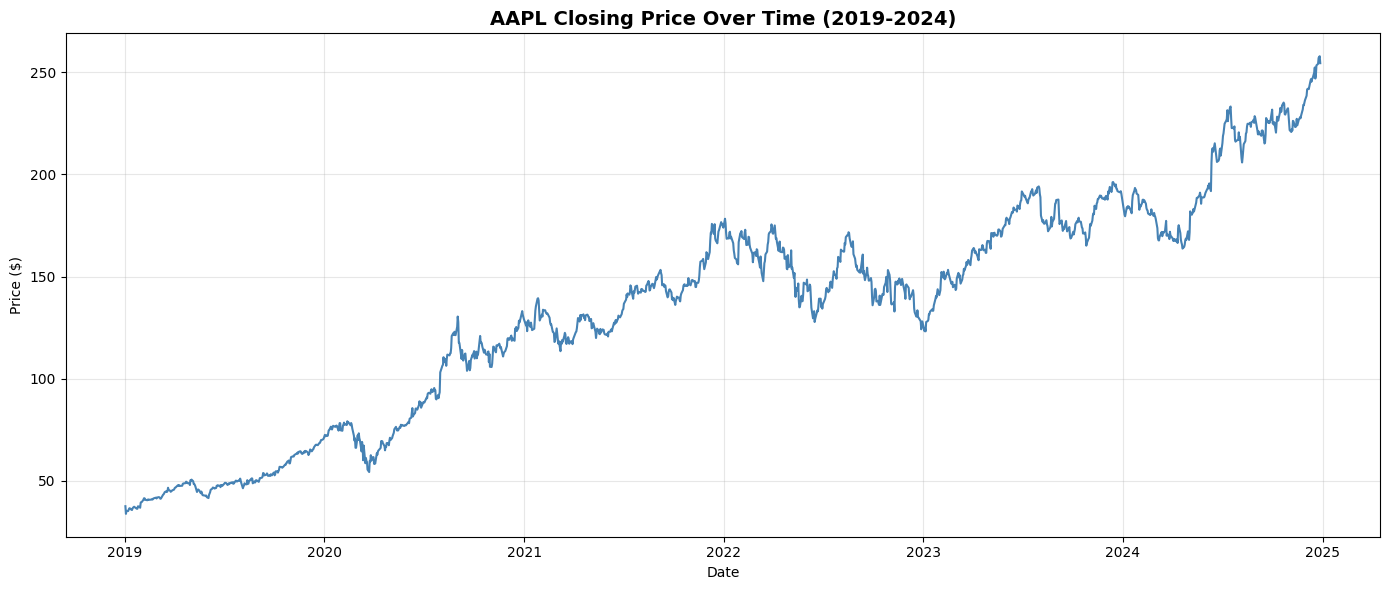

In [10]:
# Time series plot of closing price over time
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['close'], linewidth=1.5, color='steelblue')
plt.title('AAPL Closing Price Over Time (2019-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


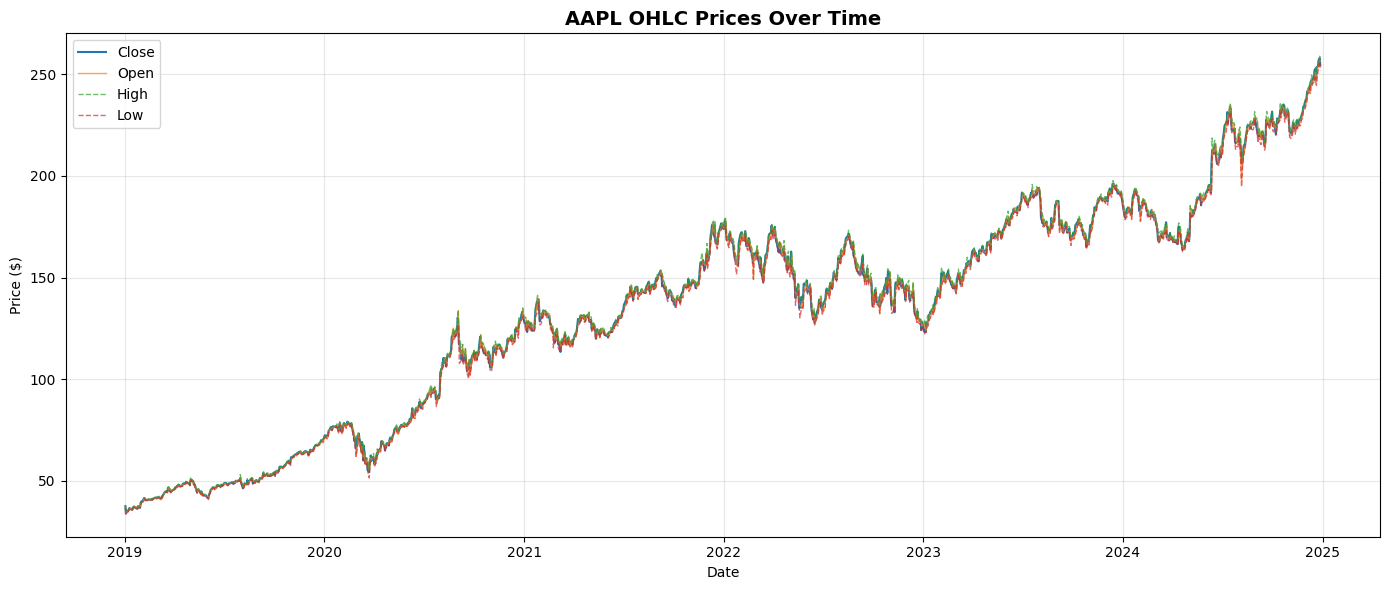

In [11]:
# Plot all OHLC prices together
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['close'], label='Close', linewidth=1.5)
plt.plot(df['date'], df['open'], label='Open', linewidth=1, alpha=0.7)
plt.plot(df['date'], df['high'], label='High', linewidth=1, alpha=0.7, linestyle='--')
plt.plot(df['date'], df['low'], label='Low', linewidth=1, alpha=0.7, linestyle='--')
plt.title('AAPL OHLC Prices Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


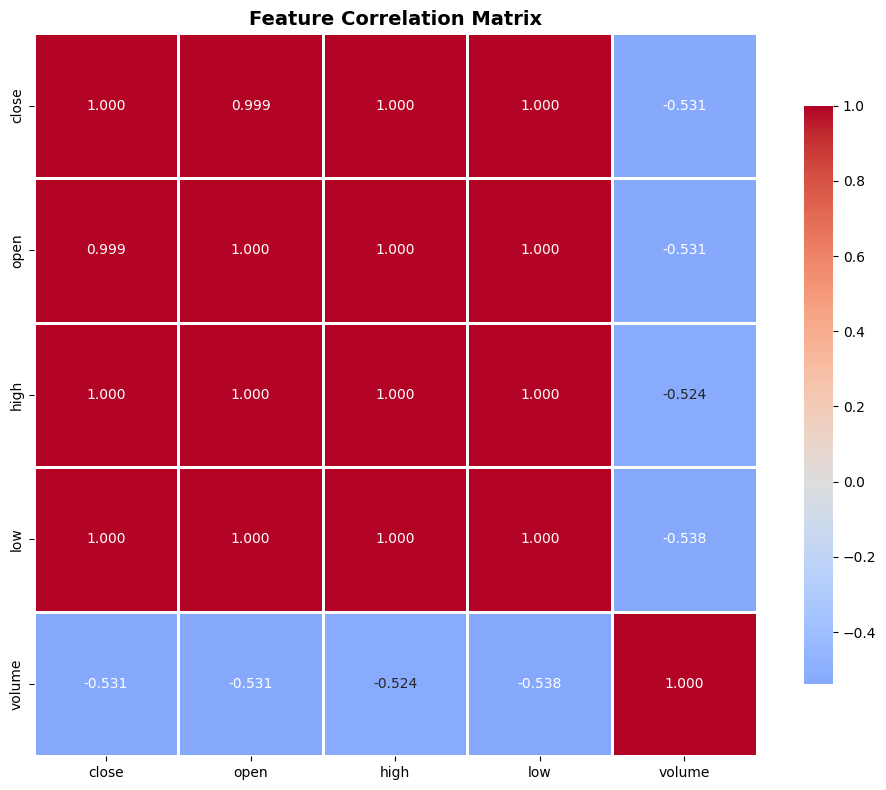

In [12]:
# Correlation matrix heatmap
correlation_matrix = df[['close', 'open', 'high', 'low', 'volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


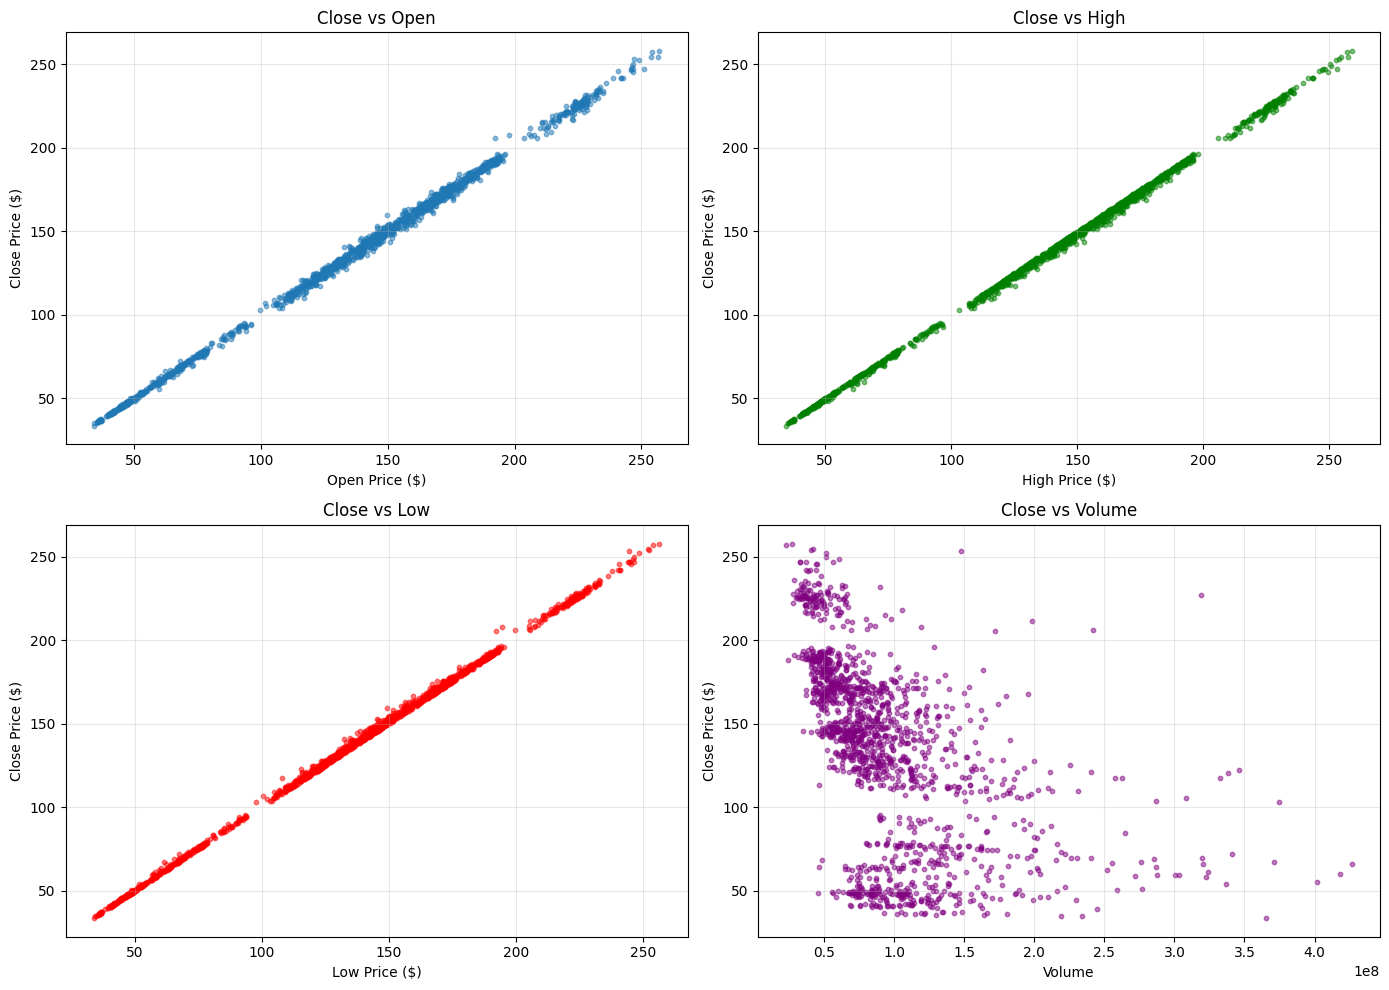

In [13]:
# Scatter plots: Close vs other price features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(df['open'], df['close'], alpha=0.5, s=10)
axes[0, 0].set_xlabel('Open Price ($)')
axes[0, 0].set_ylabel('Close Price ($)')
axes[0, 0].set_title('Close vs Open')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(df['high'], df['close'], alpha=0.5, s=10, color='green')
axes[0, 1].set_xlabel('High Price ($)')
axes[0, 1].set_ylabel('Close Price ($)')
axes[0, 1].set_title('Close vs High')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(df['low'], df['close'], alpha=0.5, s=10, color='red')
axes[1, 0].set_xlabel('Low Price ($)')
axes[1, 0].set_ylabel('Close Price ($)')
axes[1, 0].set_title('Close vs Low')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['volume'], df['close'], alpha=0.5, s=10, color='purple')
axes[1, 1].set_xlabel('Volume')
axes[1, 1].set_ylabel('Close Price ($)')
axes[1, 1].set_title('Close vs Volume')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


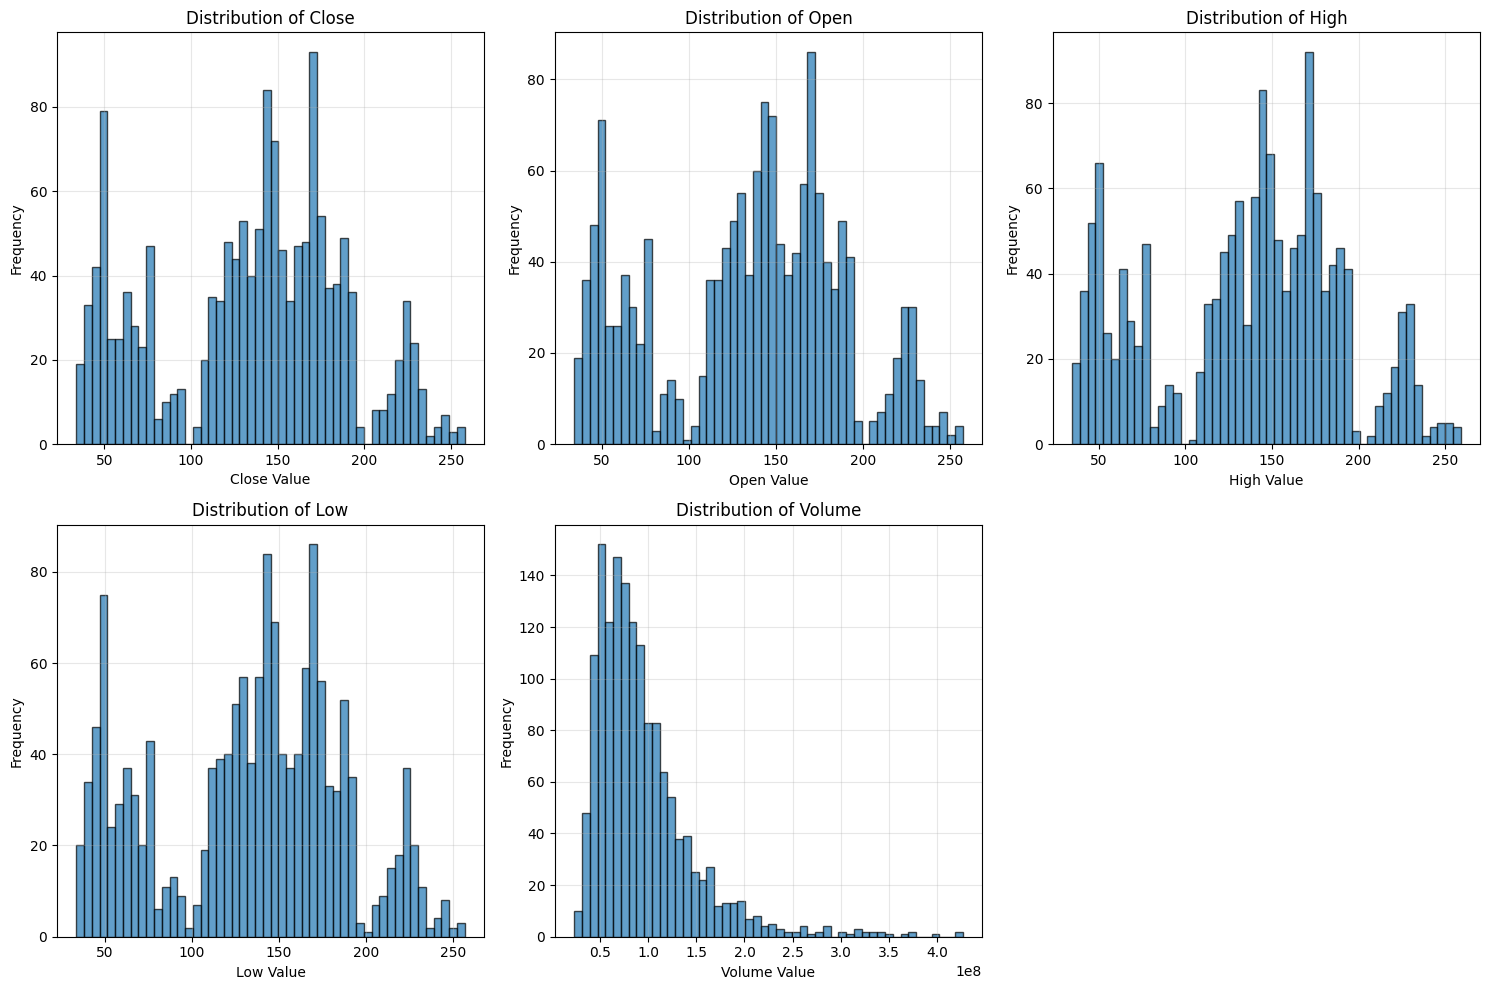

In [14]:
# Distribution plots (histograms) for each feature
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = ['close', 'open', 'high', 'low', 'volume']
for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    axes[row, col].hist(df[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_xlabel(f'{feature.capitalize()} Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Distribution of {feature.capitalize()}')
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


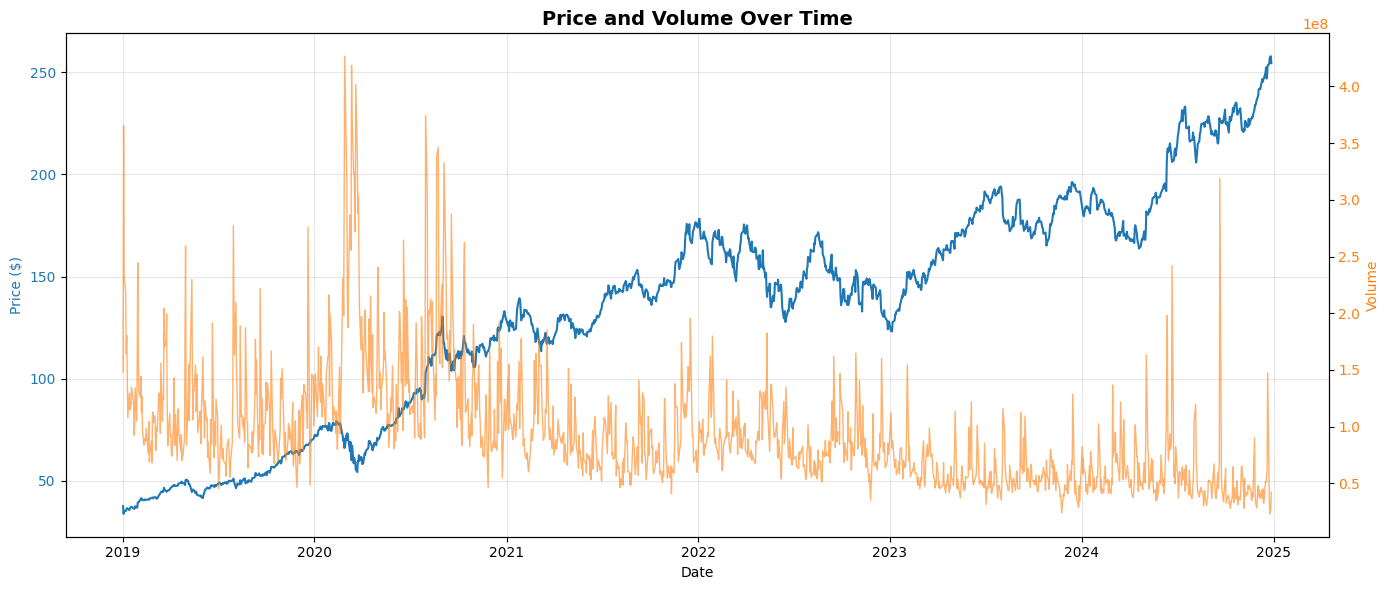

In [15]:
# Volume vs Price analysis (dual y-axis)
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)', color=color)
ax1.plot(df['date'], df['close'], color=color, linewidth=1.5, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Volume', color=color)
ax2.plot(df['date'], df['volume'], color=color, linewidth=1, alpha=0.6, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Price and Volume Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()


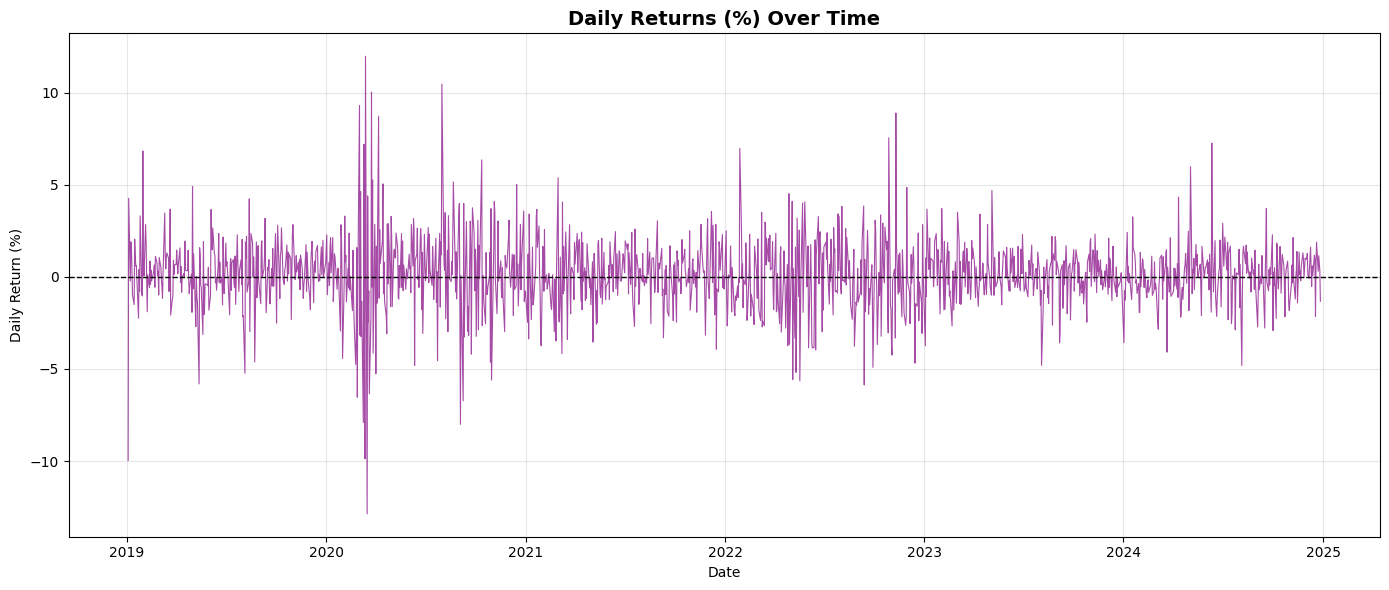

Daily Return Statistics:
  Mean: 0.1459%
  Std:  1.9435%
  Min:  -12.86%
  Max:  11.98%


In [16]:
# Calculate and plot daily returns
df['daily_return'] = df['close'].pct_change() * 100  # Percentage return

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['daily_return'], linewidth=0.8, alpha=0.7, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Daily Returns (%) Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Daily Return Statistics:")
print(f"  Mean: {df['daily_return'].mean():.4f}%")
print(f"  Std:  {df['daily_return'].std():.4f}%")
print(f"  Min:  {df['daily_return'].min():.2f}%")
print(f"  Max:  {df['daily_return'].max():.2f}%")


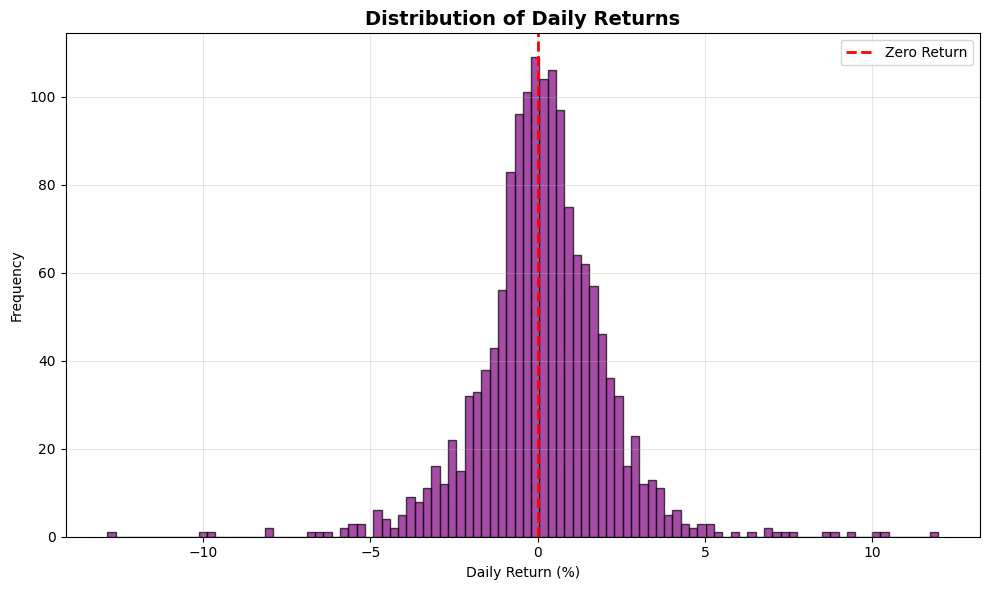

In [17]:
# Distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(df['daily_return'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='purple')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Return')
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


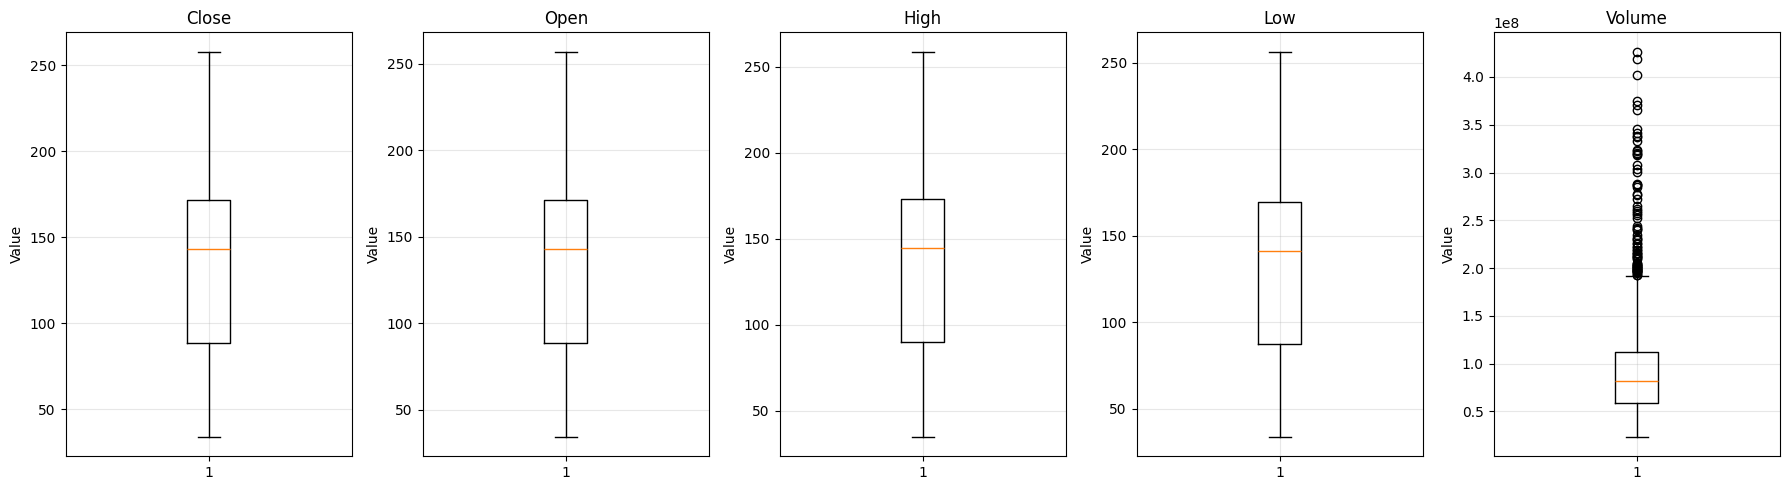

In [18]:
# Box plots to detect outliers
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

features_to_plot = ['close', 'open', 'high', 'low', 'volume']
for idx, feature in enumerate(features_to_plot):
    axes[idx].boxplot(df[feature], vert=True)
    axes[idx].set_ylabel('Value')
    axes[idx].set_title(f'{feature.capitalize()}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# Summary statistics table
print("="*60)
print("DATA EXPLORATION SUMMARY")
print("="*60)
print(f"\nDataset Shape: {df.shape}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Total Trading Days: {len(df)}")
print(f"\nPrice Range:")
print(f"  Close: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
print(f"  Open:  ${df['open'].min():.2f} - ${df['open'].max():.2f}")
print(f"\nVolume Range:")
print(f"  Min: {df['volume'].min():,.0f}")
print(f"  Max: {df['volume'].max():,.0f}")
print(f"  Mean: {df['volume'].mean():,.0f}")
print("="*60)


DATA EXPLORATION SUMMARY

Dataset Shape: (1508, 7)
Date Range: 2019-01-02 00:00:00 to 2024-12-27 00:00:00
Total Trading Days: 1508

Price Range:
  Close: $33.80 - $257.85
  Open:  $34.23 - $257.03

Volume Range:
  Min: 23,234,700
  Max: 426,510,000
  Mean: 94,242,882


Select Features

In [20]:
features = ['close', 'open', 'high', 'low', 'volume']
data = df[features].values

print(f"Selected features: {features}")
print(f"Feature array shape: {data.shape}")

Selected features: ['close', 'open', 'high', 'low', 'volume']
Feature array shape: (1508, 5)


In [21]:
print(f"\nPrice statistics (recent data):")
print(f"  Min: ${data[:, 0].min():.2f}")
print(f"  Max: ${data[:, 0].max():.2f}")
print(f"  Mean: ${data[:, 0].mean():.2f}")


Price statistics (recent data):
  Min: $33.80
  Max: $257.85
  Mean: $134.53


Split Train / Val / Test

In [22]:
n_total = len(data)
train_ratio = 0.7
val_ratio = 0.15

train_size = int(n_total * train_ratio)
val_size = int(n_total * val_ratio)
test_size = n_total - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

train_dates = df['date'].iloc[:train_size]
val_dates = df['date'].iloc[train_size:train_size+val_size]
test_dates = df['date'].iloc[train_size+val_size:]

In [23]:
print(f"Total samples: {n_total}")
print(f"Train: {train_size} samples (70%)")
print(f"Val:   {val_size} samples (15%)")
print(f"Test:  {test_size} samples (15%)")

print(f"\nDate ranges:")
print(f"  Train: {train_dates.min()} to {train_dates.max()}")
print(f"  Val:   {val_dates.min()} to {val_dates.max()}")
print(f"  Test:  {test_dates.min()} to {test_dates.max()}")

Total samples: 1508
Train: 1055 samples (70%)
Val:   226 samples (15%)
Test:  227 samples (15%)

Date ranges:
  Train: 2019-01-02 00:00:00 to 2023-03-10 00:00:00
  Val:   2023-03-13 00:00:00 to 2024-02-02 00:00:00
  Test:  2024-02-05 00:00:00 to 2024-12-27 00:00:00


Scale Data

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

os.makedirs('./models', exist_ok=True)
joblib.dump(scaler, './models/scaler_recent.gz')

['./models/scaler_recent.gz']

Create Sequences

In [25]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [26]:
SEQUENCE_LENGTH = 60

X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH)

train_tail = train_scaled[-SEQUENCE_LENGTH:]
val_with_context = np.vstack([train_tail, val_scaled])
X_val, y_val = create_sequences(val_with_context, SEQUENCE_LENGTH)

val_tail = val_scaled[-SEQUENCE_LENGTH:]
test_with_context = np.vstack([val_tail, test_scaled])
X_test, y_test = create_sequences(test_with_context, SEQUENCE_LENGTH)

print(f"✓ Train: X={X_train.shape}, y={y_train.shape}")
print(f"✓ Val:   X={X_val.shape}, y={y_val.shape}")
print(f"✓ Test:  X={X_test.shape}, y={y_test.shape}")

✓ Train: X=(995, 60, 5), y=(995,)
✓ Val:   X=(226, 60, 5), y=(226,)
✓ Test:  X=(227, 60, 5), y=(227,)


Build the LSTM Model

In [27]:
custom_optimizer = Adam(learning_rate=0.001)

model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(features)), kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    
    LSTM(150, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.25),

    
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    
    Dense(1)
])

c:\Users\bello\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 200)        │       164,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 150)        │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,901 (1.82 MB)

 Trainable params: 475,901 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [29]:
# 7. TRAIN
# ============================================
print("\n" + "="*60)
print("7. TRAINING")
print("="*60)

checkpoint = ModelCheckpoint(
    './models/best_model_recent.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


7. TRAINING
Epoch 1/200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3371 - mae: 0.1848
Epoch 1: val_loss improved from None to 0.15317, saving model to ./models/best_model_recent.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.2565 - mae: 0.1113 - val_loss: 0.1532 - val_mae: 0.0407
Epoch 2/200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1358 - mae: 0.0620
Epoch 2: val_loss improved from 0.15317 to 0.08198, saving model to ./models/best_model_recent.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1169 - mae: 0.0595 - val_loss: 0.0820 - val_mae: 0.0576
Epoch 3/200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0740 - mae: 0.0518
Epoch 3: val_loss improved from 0.08198 to 0.05273, saving model to ./models/best_model_recent.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0665 - mae: 0.0508 - val_loss: 0.0527 - val_mae: 0.0556
Epoch 4/200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0495 - mae: 0.0508
Epoch 4: val_loss improved from 0.05273 to 0.

Predict

In [33]:
best_model = load_model('./models/best_model_recent.keras')

y_train_pred_scaled = best_model.predict(X_train, verbose=0)
y_val_pred_scaled = best_model.predict(X_val, verbose=0)
y_test_pred_scaled = best_model.predict(X_test, verbose=0)

Inverse Scaling

In [34]:
def inverse_transform_predictions(y_scaled, scaler, n_features):
    n = len(y_scaled)
    dummy = np.ones((n, n_features))
    dummy[:, 0] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

In [35]:
y_train_actual = inverse_transform_predictions(y_train.reshape(-1, 1), scaler, len(features))
y_train_pred = inverse_transform_predictions(y_train_pred_scaled, scaler, len(features))

y_val_actual = inverse_transform_predictions(y_val.reshape(-1, 1), scaler, len(features))
y_val_pred = inverse_transform_predictions(y_val_pred_scaled, scaler, len(features))

y_test_actual = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, len(features))
y_test_pred = inverse_transform_predictions(y_test_pred_scaled, scaler, len(features))

Metrics

In [36]:
def calc_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

In [37]:
mae_train, rmse_train, mape_train = calc_metrics(y_train_actual, y_train_pred)
mae_val, rmse_val, mape_val = calc_metrics(y_val_actual, y_val_pred)
mae_test, rmse_test, mape_test = calc_metrics(y_test_actual, y_test_pred)

print("\n" + "="*60)
print("📊 FINAL RESULTS (RECENT DATA)")
print("="*60)
print(f"{'Dataset':<10} {'MAE':<12} {'RMSE':<12} {'MAPE':<12}")
print("-"*60)
print(f"{'Train':<10} ${mae_train:<11.2f} ${rmse_train:<11.2f} {mape_train:<11.2f}%")
print(f"{'Val':<10} ${mae_val:<11.2f} ${rmse_val:<11.2f} {mape_val:<11.2f}%")
print(f"{'Test':<10} ${mae_test:<11.2f} ${rmse_test:<11.2f} {mape_test:<11.2f}%")
print("="*60)

if mape_test < 5:
    print("✅ Excellent !")
elif mape_test < 10:
    print("Good !")
else:
    print("Still needs work !")


📊 FINAL RESULTS (RECENT DATA)
Dataset    MAE          RMSE         MAPE        
------------------------------------------------------------
Train      $3.48        $4.54        3.24       %
Val        $3.05        $3.79        1.71       %
Test       $4.37        $5.87        2.10       %
✅ Excellent !


Visualizations

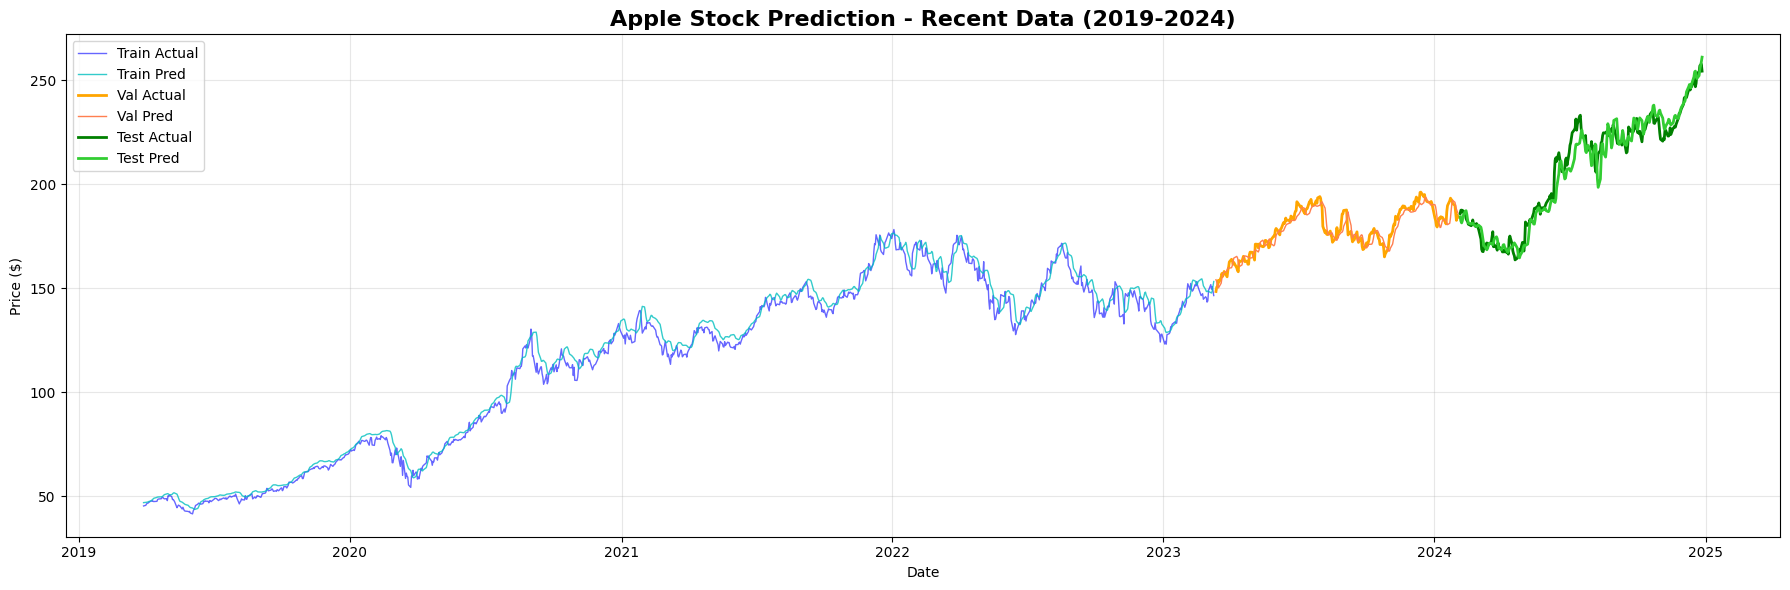

In [38]:
train_dates_plot = train_dates.iloc[SEQUENCE_LENGTH:].values
val_dates_plot = val_dates.values
test_dates_plot = test_dates.values

# Full plot
plt.figure(figsize=(18, 6))

plt.plot(train_dates_plot, y_train_actual, 'b-', alpha=0.6, linewidth=1, label='Train Actual')
plt.plot(train_dates_plot, y_train_pred, 'c-', alpha=0.8, linewidth=1, label='Train Pred')

plt.plot(val_dates_plot, y_val_actual, 'orange', linewidth=2, label='Val Actual')
plt.plot(val_dates_plot, y_val_pred, 'coral', linewidth=1, label='Val Pred')

plt.plot(test_dates_plot, y_test_actual, 'green', linewidth=2, label='Test Actual')
plt.plot(test_dates_plot, y_test_pred, 'limegreen', linewidth=2, label='Test Pred')

plt.title('Apple Stock Prediction - Recent Data (2019-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

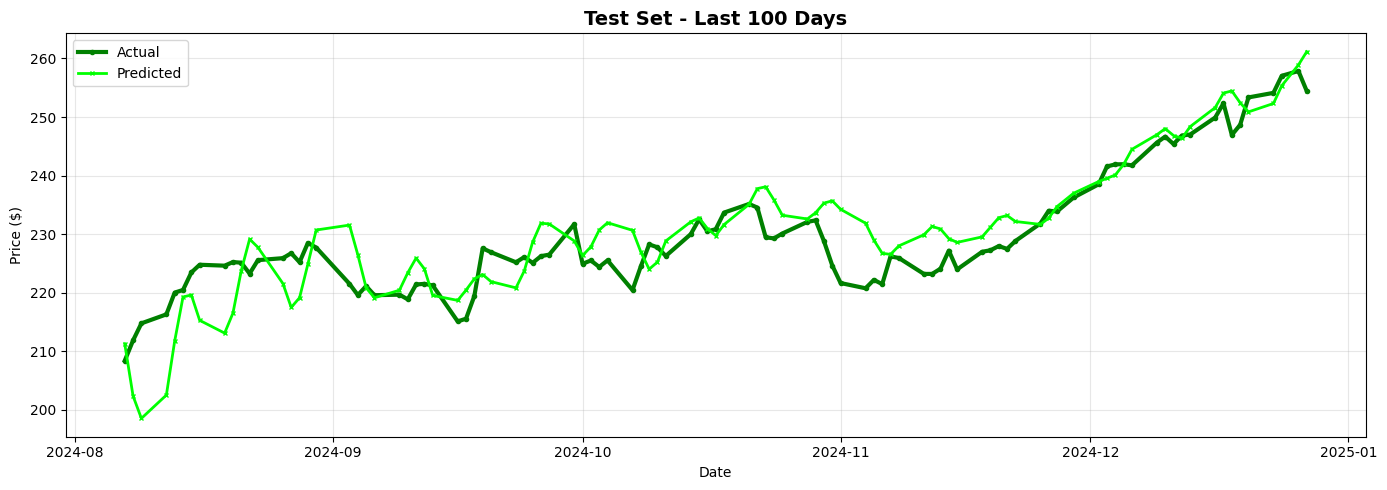

In [39]:
# Test zoom
plt.figure(figsize=(14, 5))
recent = min(100, len(test_dates_plot))
plt.plot(test_dates_plot[-recent:], y_test_actual[-recent:], 
         'g-', linewidth=3, marker='o', markersize=3, label='Actual')
plt.plot(test_dates_plot[-recent:], y_test_pred[-recent:], 
         'lime', linewidth=2, marker='x', markersize=3, label='Predicted')
plt.title(f'Test Set - Last {recent} Days', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

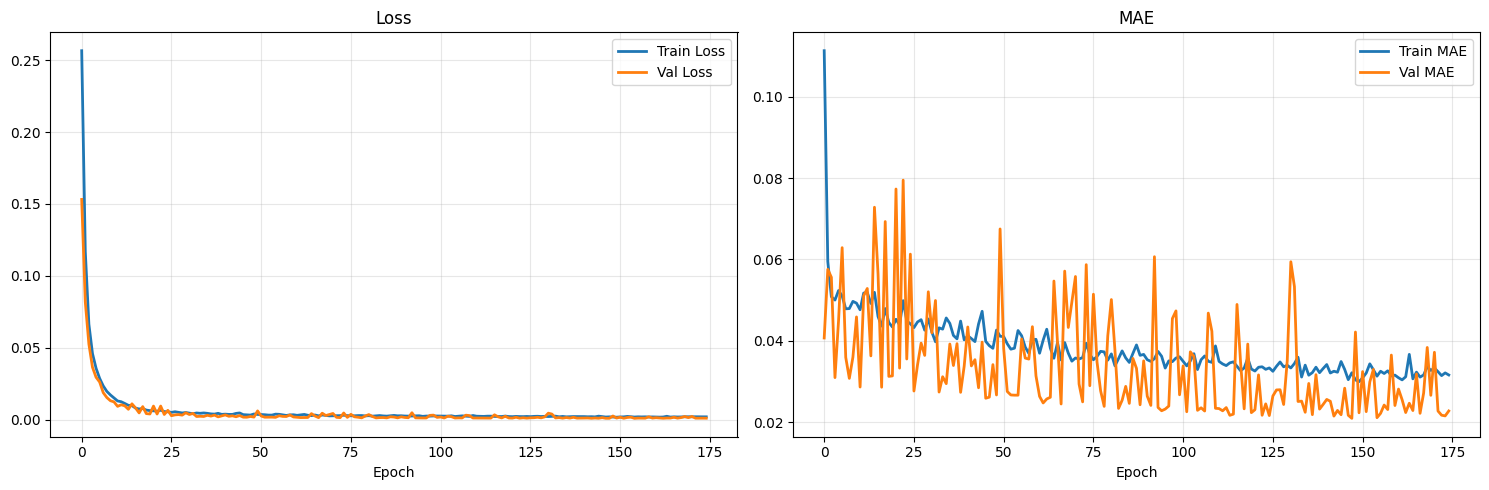

In [40]:
# Training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], linewidth=2, label='Train Loss')
ax1.plot(history.history['val_loss'], linewidth=2, label='Val Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['mae'], linewidth=2, label='Train MAE')
ax2.plot(history.history['val_mae'], linewidth=2, label='Val MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()